## Méthode Linear Regression sur le dataset LivingRoom_preprocessed_hack

In [1]:
import os

import pandas as pd
import s3fs
import zipfile
import matplotlib.pyplot as plt

### Récupérer les données du challenge

In [14]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [15]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [16]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [17]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

KeyboardInterrupt: 

In [ ]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

NB : les données peuvent être également téléchargées directement si besoin, pour être utilisées hors du SSP CLoud.
Exemple pour le fichier ci-dessus (même format de lien pour les autres challenges) : 

http://minio.lab.sspcloud.fr/gvimont/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip

### Exporter des données

In [3]:
import numpy as np
import pandas as pd

# Load the Empty Room .npy file
data_empty = np.load('data/LivingRoom_preprocessed_hack/Empty/deconvolved.npy')


# Load the Human1 Room .npy file
data_H1_target = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')
data_H1_features = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
#data_array_H1_skeletons = np.load('data/LivingRoom_preprocessed_hack/Human1/skeletons.npy')


# Load the Human2 Room .npy file
data_H2_target = np.load('data/LivingRoom_preprocessed_hack/Human2/centroid.npy')
data_H2_features = np.load('data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy')
#data_array_H2_skeletons = np.load('data/LivingRoom_preprocessed_hack/Human2/skeletons.npy')



(100, 10, 667200)


Affichage des données dans la salle vide

In [5]:
print(data_empty)

[[[ 3.51455710e-05  2.98663563e-05  3.73540461e-05 ...  3.15141187e-05
    3.39845319e-05  3.76356365e-05]
  [ 2.16268872e-05  1.10792007e-05  2.40492645e-05 ...  1.01209635e-05
    1.73616045e-05  8.96632082e-06]
  [ 2.06858294e-05  1.90607770e-05  2.63220481e-05 ...  1.43677271e-05
    1.95061293e-05  1.58852017e-05]
  ...
  [ 3.27473884e-07 -3.45638477e-06  6.21833306e-06 ...  1.55723665e-05
    7.87512818e-06  1.52851735e-05]
  [-3.58676079e-05 -3.13848795e-05 -2.27468136e-05 ... -3.73245530e-06
   -5.06659762e-06 -9.37922323e-06]
  [ 2.69082539e-05  1.57103223e-05  2.85315637e-05 ...  1.50174383e-05
    1.78934224e-05  1.78581904e-05]]

 [[-2.38466669e-06 -1.65329311e-06 -2.45740762e-06 ...  3.55113252e-06
    7.89113926e-07  5.85643602e-06]
  [ 3.67970802e-06  3.20152003e-06  7.42820293e-06 ...  1.00465177e-05
    8.65629227e-06  1.03361735e-05]
  [ 1.15234134e-05  9.68922814e-06  1.62094748e-05 ...  4.92468780e-06
    7.93941035e-06  4.21444474e-06]
  ...
  [-3.29118811e-05 -3.0

Affichage du son d'une expérience dans la salle vide

(0.0, 10000.0)

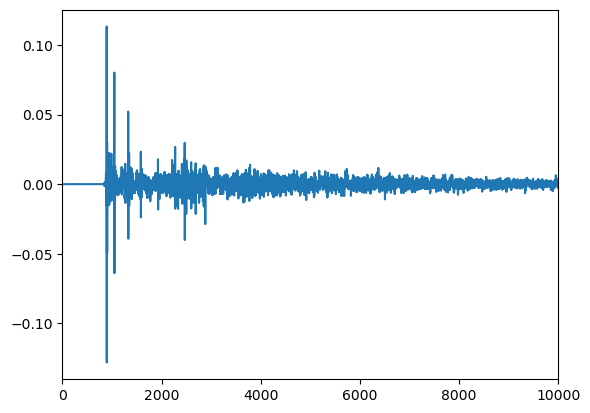

In [7]:
plt.plot(data_empty[0][0])
plt.xlim([0,10000])

### Travail sur la salle Human1

**Affichage du centroid (position (x,y) de l'humain)**

In [8]:
print(data_H1_target)

[[-3231.3293467  -1127.87771457]
 [-3198.54107875  -744.5100656 ]
 [-3192.9776274   -248.26678827]
 ...
 [-1717.89923578 -3166.59648491]
 [-1808.60337549 -2779.13038427]
 [   44.43741322   106.48353609]]


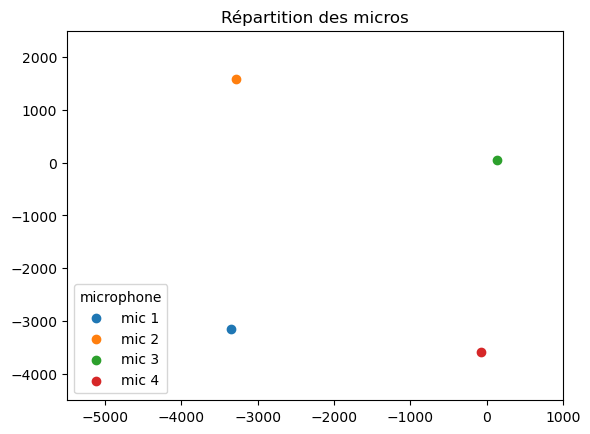

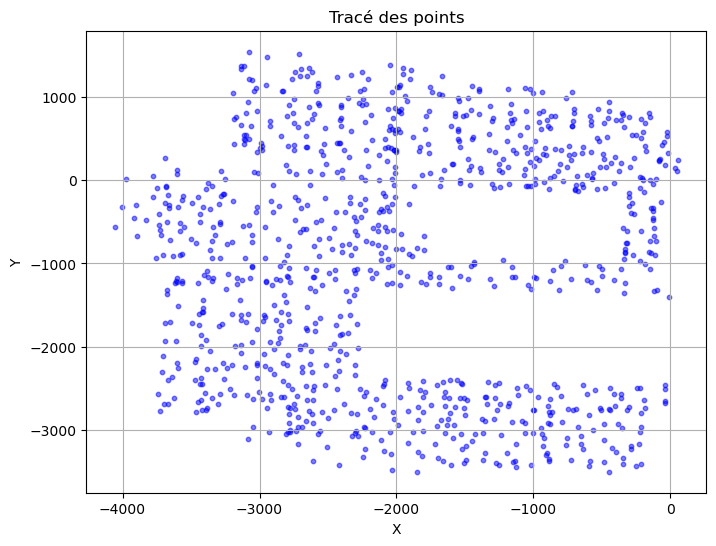

In [26]:
x = data_H1_target[:, 0]
y = data_H1_target[:, 1]

import numpy as np

# Microphone Locations
mic_height = 50.3125
feet = 12
y_tile = 23.5
x_tile = 11 +7/8

camera_origin_location = np.array([-6*x_tile-5.75, -y_tile, 45+13/16])*25.4

mic_1 = np.array([-11*x_tile - 1, -5*y_tile - 6-3/8, mic_height]) * 25.4 
mic_4= np.array([-11*x_tile + 1.25 + 1/16, 2.5*y_tile+3.75, mic_height]) * 25.4
mic_6 = np.array([5+3/8, 2+1/8, mic_height]) * 25.4
mic_9 = np.array([-3, -6*y_tile - 0.5, mic_height]) * 25.4


mic_xyzs = np.stack((mic_1,mic_4, mic_6, mic_9),axis=0)

SPEAKER_BOTTOM_RIGHT_Y = (1200.15 + 1196.975 + 1206.5)/ 3
SPEAKER_BOTTOM_RIGHT_X = (88.9 + 107.95 + 101.6) / 3
SPEAKER_BOTTOM_LEFT_Y = (1327.15 + 1311.55712764 + 1317.625) / 3
SPEAKER_BOTTOM_LEFT_X = - 76.98583188

speaker_xyz_bottom_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, 44.5*25.4])
speaker_xyz_bottom_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, 44.5*25.4])
speaker_xyz_top_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, (44.5+17)*25.4])
speaker_xyz_top_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, (44.5+17)*25.4])
speaker_xyz = (speaker_xyz_bottom_right+speaker_xyz_bottom_left+speaker_xyz_top_right+speaker_xyz_top_left)/4


walls = None
x_min = - 4000
x_max = 500
y_min = -4000
y_max = 2000


## affichier la disposition des microphones.
for idx, mic in enumerate(mic_xyzs):
    plt.scatter(mic[0], mic[1], label=f'mic {idx+1}')

plt.title("Répartition des micros")
plt.xlim([-5500, 1000])
plt.ylim([-4500, 2500])
plt.legend(loc="lower left", title="microphone")

# Tracer les points de positions de l'humain dans la pièce
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=10, c='blue', marker='o', alpha=0.5)  # s: taille des points, c: couleur, marker: type de marqueur, alpha: transparence
plt.title('Tracé des points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

**Affichage et process du deconvoled**

Affichage du dataset audio

In [11]:
print(data_H1_features.shape)
print(data_H1_features)

(1000, 4, 667200)
[[[ 9.07240337e-06  1.71257434e-05  1.22597794e-05 ...  8.86178623e-06
    1.40686043e-05  1.06616626e-05]
  [-8.23853679e-06 -8.23373648e-06 -8.74563466e-06 ...  2.87394778e-06
   -8.90485808e-06 -3.52464713e-06]
  [ 6.62780906e-07 -1.40201587e-06  1.83228190e-06 ... -1.06218545e-06
    8.53497477e-06  2.28155182e-06]
  [ 8.11119719e-07 -2.47451499e-06  5.82140547e-06 ...  7.73804004e-06
    2.29692650e-05  1.10566034e-05]]

 [[ 1.64466037e-05  1.53698293e-05  1.91599720e-05 ...  1.76548729e-05
    1.70955263e-05  1.41169767e-05]
  [ 1.05826217e-07  9.13145777e-06  1.76140716e-07 ...  1.21369967e-05
    1.55958387e-05  1.23088676e-05]
  [ 7.06836090e-06  3.26818258e-06  7.15508941e-06 ...  4.64980394e-06
    8.96262554e-06  6.55734584e-06]
  [-3.18089551e-05 -8.93297238e-06 -2.51026504e-05 ... -7.02741545e-07
    1.34268867e-05  3.24307348e-06]]

 [[ 4.71092753e-05  4.42863784e-05  4.81883108e-05 ...  5.11715079e-05
    4.54165129e-05  4.68136932e-05]
  [-2.25045878e

Affichage d'un audio

(0.0, 10000.0)

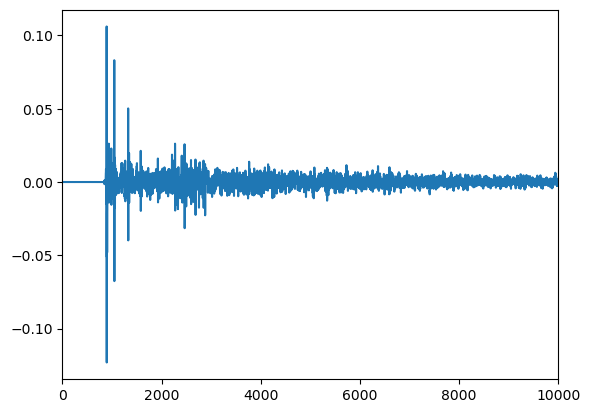

In [12]:
plt.plot(data_H1_features[0][0])
plt.xlim([0,10000])

**Modèle 1: Utilisation de la RMS pour traiter nos données et effectuer la régression linéaire**

In [11]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2024-04-24 09:13:56.237008: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 09:13:56.245036: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 09:13:56.315386: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 09:13:57.398944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [47]:
X = data_H1_features
y = data_H1_target

In [48]:
# Calcul de la RMS pour chaque canal (microphone)
rms_data = np.sqrt(np.mean(np.square(X), axis=2))
print(rms_data.shape)
# Normaliser les données RMS
scaler = StandardScaler()
rms_data = rms_data.reshape(1000,-1)
rms_data_normalized = scaler.fit_transform(rms_data)
print(rms_data_normalized)

(1000, 4)
[[  0.807686     0.89319843   0.3703625    0.55446833]
 [  0.6148092    0.5601817    0.32530993   0.49623522]
 [  0.6670591    0.46835804   0.26275572   0.5050229 ]
 ...
 [  0.48971906   0.02091012  -0.3304132   -0.05839473]
 [  0.38563752  -0.5528933   -0.33424938  -0.18044513]
 [  0.38350895   0.30132347 -10.254325    -4.594716  ]]


In [49]:
X_train, X_test, y_train, y_test = train_test_split(rms_data_normalized,y,test_size=0.2,random_state=42)

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




# initialiser le modèle de régression
linear_regression_model = LinearRegression()

# entraîner le modèle avec les données d'entraînements
linear_regression_model.fit(X_train, y_train)

# faire les prédictions avec le dataset de test
predictions = linear_regression_model.predict(X_test)

# évaluer le modèle
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)




print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R²:", r2)


Test MSE: 1379956.1731800777
Test MAE: 994.9644834742676
Test R²: 0.16508653701175757


In [51]:
import numpy as np

# Calculer la distance euclidienne entre les coordonnées prédites et les coordonnées réelles
def euclidean_distance(y_true, y_pred):
    # Calculer la différence entre les coordonnées prédites et réelles
    diff = y_true - y_pred
    # Calculer la distance euclidienne pour chaque point
    distances = np.linalg.norm(diff, axis=1)
    return distances

# Utiliser la fonction pour calculer les distances euclidiennes pour les prédictions actuelles
distances = euclidean_distance(y_test, predictions)

# Calculer la moyenne des distances
mean_distance = np.mean(distances)

print("Mean Euclidean Distance:", mean_distance)


Mean Euclidean Distance: 1544.234908824


**Méthode 2: Utilisation de PCA pour traiter les données audios et effectuer la régression linéaire**

In [22]:
from sklearn.decomposition import PCA

X_reshaped = X.reshape(1000,-1)
pca = PCA(n_components=700)
H1_dec = pca.fit_transform(X_reshaped)

In [55]:
from sklearn.decomposition import PCA

X_reshaped = X.reshape(1000,-1)
pca = PCA(n_components=100)
H1_dec = pca.fit_transform(X_reshaped)

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()

X_scaled =  scaler.fit_transform(H1_dec_reshaped)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2, random_state=42)

L_Reg = LinearRegression()

L_Reg.fit(X_train, y_train)

y_preds = L_Reg.predict(X_test)

distances = euclidean_distance(y_test, y_preds)

# Calculer la moyenne des distances
mean_distance = np.mean(distances)

print("Mean Euclidean Distance:", mean_distance)

# évaluer le modèle
mse = mean_squared_error(y_test, y_preds)
mae = mean_absolute_error(y_test, y_preds)
r2 = r2_score(y_test, y_preds)




print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R²:", r2)


Mean Euclidean Distance: 659.9249718577898
Test MSE: 319362.41540065646
Test MAE: 416.8190281836333
Test R²: 0.7923677862787171


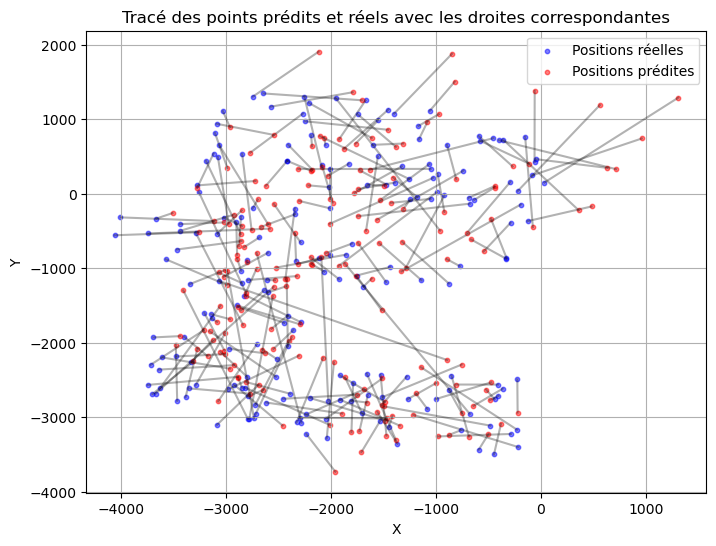

In [67]:
X_test_plot = y_test[:, 0]
y_test_plot = y_test[:, 1]

X_preds_plot = y_preds[:, 0]
y_preds_plot = y_preds[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(X_test_plot, y_test_plot, s=10, c='blue', marker='o', alpha=0.5, label='Positions réelles')
plt.scatter(X_preds_plot, y_preds_plot, s=10, c='red', marker='o', alpha=0.5, label='Positions prédites')  # s: taille des points, c: couleur, marker: type de marqueur, alpha: transparence

for i in range(len(X_test_plot)):
    plt.plot([X_test_plot[i], X_preds_plot[i]], [y_test_plot[i], y_preds_plot[i]], c='black', alpha=0.3)

plt.title('Tracé des points prédits et réels avec les droites correspondantes')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

In [70]:
import numpy as np

# Calcul de la distance euclidienne entre chaque position prédite et réelle
distances_euclidiennes = np.sqrt((X_preds_plot - X_test_plot)**2 + (y_preds_plot - y_test_plot)**2)

# Comparaison et calcul de l'accuracy
predictions_correctes = np.sum(distances_euclidiennes <= mean_distance)
accuracy = predictions_correctes / len(distances_euclidiennes)

print("Précision du modèle :", accuracy*100)

Précision du modèle : 58.5


### Travail sur la salle H2

**Affichage du centroid**

In [ ]:
print(data_array_H2_centroid)

[[-2406.85413008 -2443.62906004]
 [-1923.16230038 -2504.30576997]
 [-1615.29307549 -2525.71107555]
 [-1234.84729435 -2581.21590946]
 [ -906.89320474 -2648.96828851]
 [ -579.82451164 -2563.38746474]
 [ -258.89043633 -2501.99822189]
 [ -237.00812692 -2957.79113999]
 [ -608.16773853 -2894.26845589]
 [ -920.67771947 -2892.68441764]
 [-1177.38289287 -3050.12473983]
 [-1690.95162773 -3023.00826184]
 [-1968.49135428 -3048.59689339]
 [-2401.44182176 -2925.40384273]
 [-2626.65068051 -2353.52639219]
 [-2945.10567004 -2270.29924636]
 [-3288.80884616 -2179.77519901]
 [-3543.43725461 -2122.72140672]
 [-3818.97939345 -2074.06640841]
 [-3787.00508742 -1745.78914635]
 [-3440.47071217 -1786.24662486]
 [-3126.89926719 -1778.7456592 ]
 [-2780.8277654  -1806.35696377]
 [-2443.03492952 -1839.64542774]
 [-2359.37110303 -1517.60616977]
 [-2643.69001771 -1476.99863966]
 [-3045.54399981 -1635.42668901]
 [-3302.78792751 -1472.55710516]
 [-3760.33837488 -1417.04328708]
 [-4041.78587419 -1398.58686915]
 [-3651.45

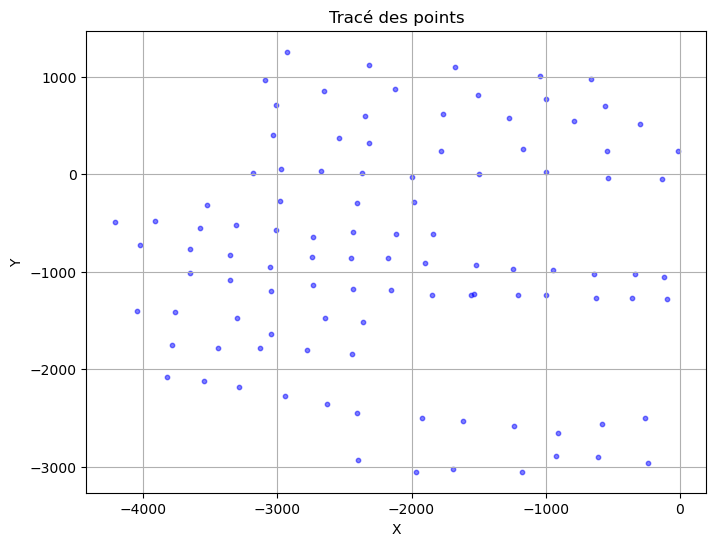

In [ ]:
x = data_array_H2_centroid[:, 0]
y = data_array_H2_centroid[:, 1]

# Tracer les points
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=10, c='blue', marker='o', alpha=0.5)  # s: taille des points, c: couleur, marker: type de marqueur, alpha: transparence
plt.title('Tracé des points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

**Affichage et process du deconvoled**